# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

C:\Users\Karin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, use_scheduler=False, fig=None):    
    loss_history = []
    train_history = []
    val_history = []
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=2, gamma=0.5) 
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %f, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        if use_scheduler:
            scheduler.step()

    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    pred_list = []
    test_list = []

    for test_X, test_Y in loader:
        pred_list.append(torch.argmax(model(test_X), dim=1))
        test_list.append(test_Y)

    pred_list = torch.hstack(pred_list)
    test_list = torch.hstack(test_list)
    
    accuracy = torch.sum(test_list == pred_list)/len(pred_list)    
    
    return accuracy

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential( 
       Flattener(),
       nn.Linear(3*32*32, 100),
       nn.ReLU(inplace=True),
       nn.Linear(100, 100),
       nn.ReLU(inplace=True),
       nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 0.000000, Average loss: 2.158981, Train accuracy: 0.205764, Val accuracy: 0.242646
Epoch: 1.000000, Average loss: 1.949646, Train accuracy: 0.310344, Val accuracy: 0.361682
Epoch: 2.000000, Average loss: 1.778148, Train accuracy: 0.390933, Val accuracy: 0.392601
Epoch: 3.000000, Average loss: 1.719395, Train accuracy: 0.412944, Val accuracy: 0.412805
Epoch: 4.000000, Average loss: 1.694184, Train accuracy: 0.424598, Val accuracy: 0.417582


Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10), 
        )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.071657, Train accuracy: 0.292837, Val accuracy: 0.409119
Average loss: 1.782791, Train accuracy: 0.458673, Val accuracy: 0.519214
Average loss: 1.650285, Train accuracy: 0.540917, Val accuracy: 0.591359
Average loss: 1.565274, Train accuracy: 0.581135, Val accuracy: 0.614907
Average loss: 1.503738, Train accuracy: 0.608248, Val accuracy: 0.621323


Добавьте уменьшение скорости обучения по ходу тренировки.

In [8]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10), 
        )

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, use_scheduler=True)

Epoch: 0.000000, Average loss: 2.389956, Train accuracy: 0.094871, Val accuracy: 0.100266
Epoch: 1.000000, Average loss: 2.389947, Train accuracy: 0.094871, Val accuracy: 0.098560
Epoch: 2.000000, Average loss: 2.390282, Train accuracy: 0.094342, Val accuracy: 0.100266
Epoch: 3.000000, Average loss: 2.390035, Train accuracy: 0.095656, Val accuracy: 0.100130
Epoch: 4.000000, Average loss: 2.389907, Train accuracy: 0.095417, Val accuracy: 0.101085


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [12]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    local_sampler = SubsetSampler(indices)
    local_loader = torch.utils.data.DataLoader(data_train, batch_size=dataset.__len__(), sampler=local_sampler)
    
    for train_X, train_Y in local_loader:
        predictions = torch.argmax(model(train_X), dim=1).numpy()
        ground_truth = train_Y.numpy()
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

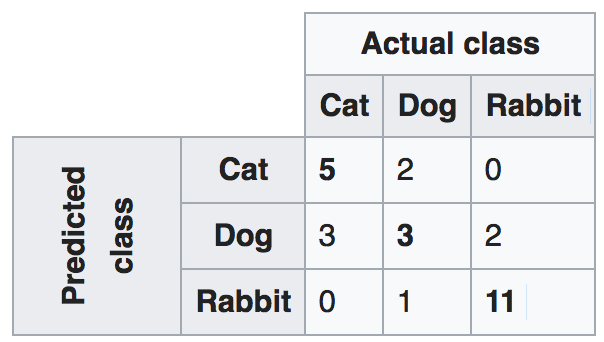

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

C:\Users\Karin\AppData\Local\Temp\ipykernel_14608\1797536855.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


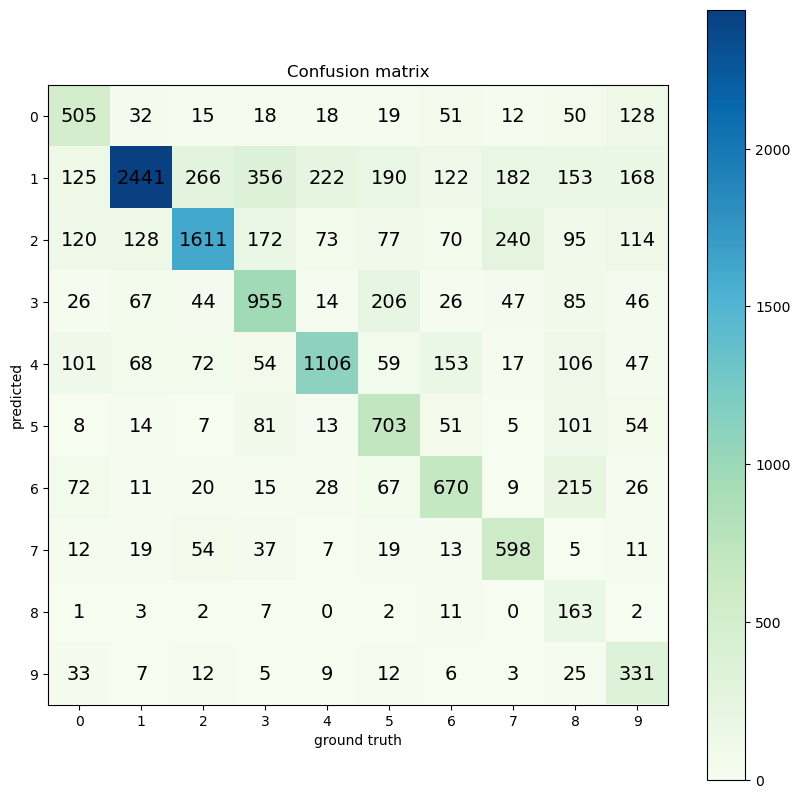

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    # TODO: Implement filling the prediction matrix
    for index, pred in enumerate(predictions):
        gt = ground_truth[index]
        confusion_matrix[pred, gt] +=1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

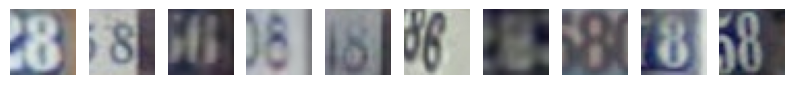

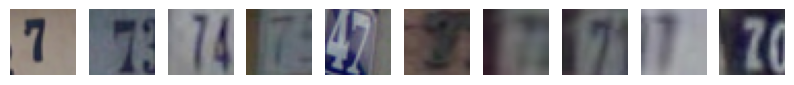

In [45]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    pred_indexes = val_indices[np.argwhere(predictions == predicted_class).squeeze()]
    gt_indexes = val_indices[np.argwhere(groud_truth == gt_class).squeeze()]
    indexes = np.intersect1d(pred_indexes, gt_indexes)
    visualize_images(indexes, data, title='', max_num=10)
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

<IPython.core.display.Javascript object>


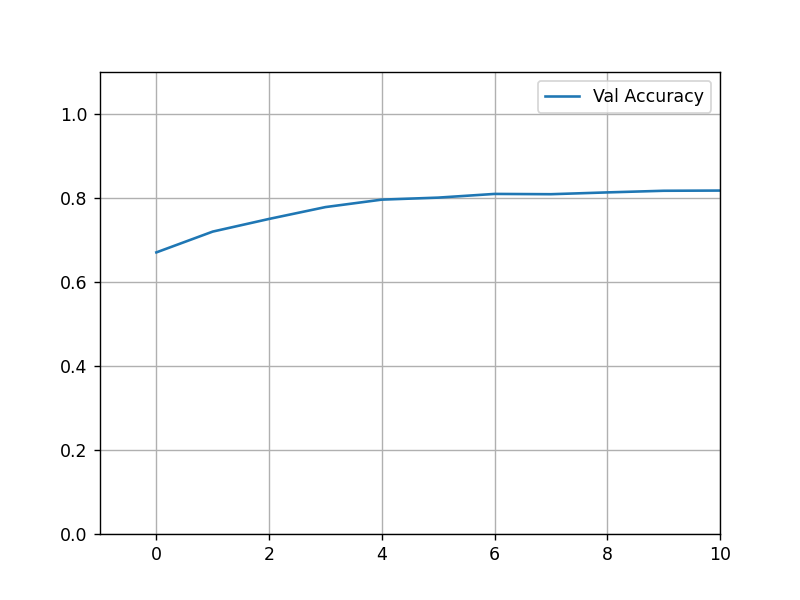

Epoch: 0.000000, Average loss: 1.401860, Train accuracy: 0.539586, Val accuracy: 0.670466
Epoch: 1.000000, Average loss: 0.992349, Train accuracy: 0.688394, Val accuracy: 0.720019
Epoch: 2.000000, Average loss: 0.832460, Train accuracy: 0.740487, Val accuracy: 0.750188
Epoch: 3.000000, Average loss: 0.775021, Train accuracy: 0.758506, Val accuracy: 0.778377
Epoch: 4.000000, Average loss: 0.701409, Train accuracy: 0.782002, Val accuracy: 0.796123
Epoch: 5.000000, Average loss: 0.685856, Train accuracy: 0.786336, Val accuracy: 0.800901
Epoch: 6.000000, Average loss: 0.642202, Train accuracy: 0.802819, Val accuracy: 0.809706
Epoch: 7.000000, Average loss: 0.631355, Train accuracy: 0.804935, Val accuracy: 0.809023
Epoch: 8.000000, Average loss: 0.611505, Train accuracy: 0.812169, Val accuracy: 0.813323
Epoch: 9.000000, Average loss: 0.607224, Train accuracy: 0.813176, Val accuracy: 0.817214
Epoch: 10.000000, Average loss: 0.595726, Train accuracy: 0.815411, Val accuracy: 0.817692
Epoch: 11

<IPython.core.display.Javascript object>


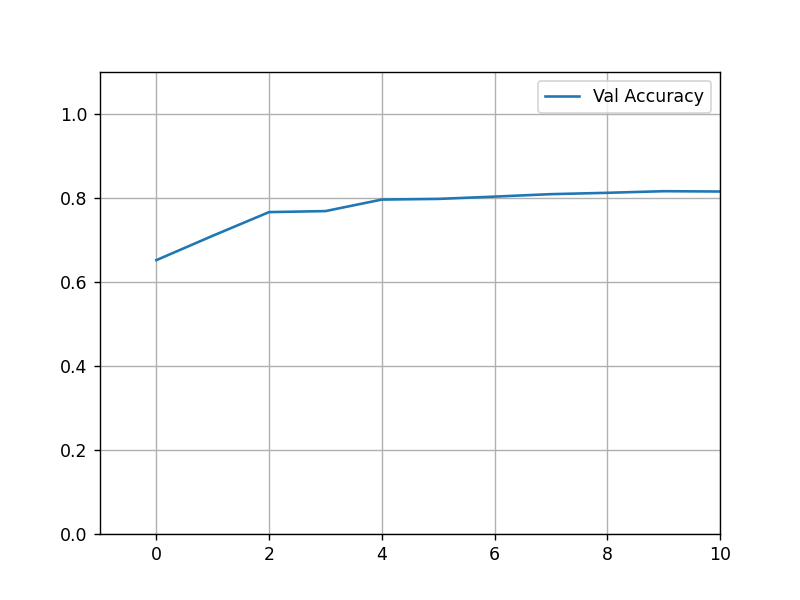

Epoch: 0.000000, Average loss: 1.420774, Train accuracy: 0.533034, Val accuracy: 0.652037
Epoch: 1.000000, Average loss: 0.998601, Train accuracy: 0.686141, Val accuracy: 0.710054
Epoch: 2.000000, Average loss: 0.833661, Train accuracy: 0.741340, Val accuracy: 0.766432
Epoch: 3.000000, Average loss: 0.782565, Train accuracy: 0.756697, Val accuracy: 0.768821
Epoch: 4.000000, Average loss: 0.709687, Train accuracy: 0.780193, Val accuracy: 0.796260
Epoch: 5.000000, Average loss: 0.685331, Train accuracy: 0.787035, Val accuracy: 0.797830
Epoch: 6.000000, Average loss: 0.651197, Train accuracy: 0.799270, Val accuracy: 0.803290
Epoch: 7.000000, Average loss: 0.636283, Train accuracy: 0.802307, Val accuracy: 0.809160
Epoch: 8.000000, Average loss: 0.620098, Train accuracy: 0.808671, Val accuracy: 0.812368
Epoch: 9.000000, Average loss: 0.612112, Train accuracy: 0.810207, Val accuracy: 0.816190
Epoch: 10.000000, Average loss: 0.603935, Train accuracy: 0.812886, Val accuracy: 0.815439
Epoch: 11

<IPython.core.display.Javascript object>


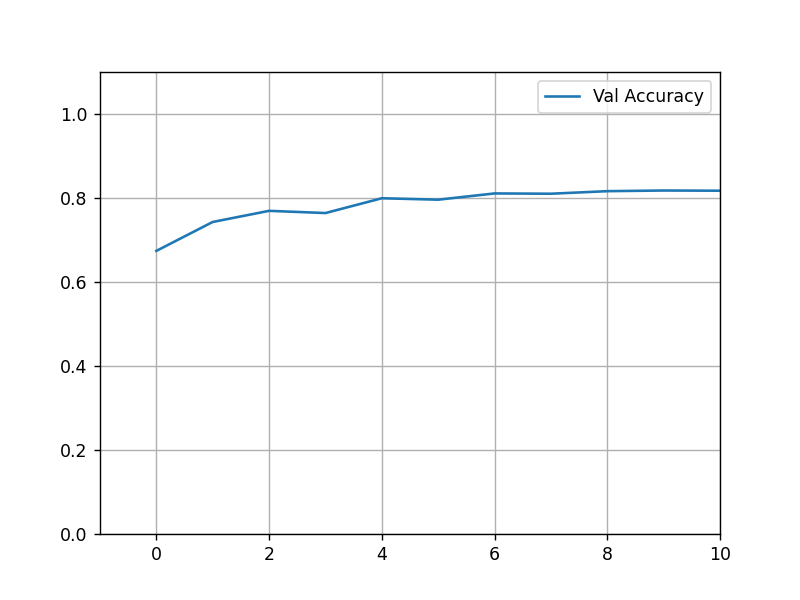

Epoch: 0.000000, Average loss: 1.404902, Train accuracy: 0.539399, Val accuracy: 0.674084
Epoch: 1.000000, Average loss: 0.984016, Train accuracy: 0.693803, Val accuracy: 0.742953
Epoch: 2.000000, Average loss: 0.822412, Train accuracy: 0.744139, Val accuracy: 0.769436
Epoch: 3.000000, Average loss: 0.772302, Train accuracy: 0.759888, Val accuracy: 0.764180
Epoch: 4.000000, Average loss: 0.703409, Train accuracy: 0.782736, Val accuracy: 0.799399
Epoch: 5.000000, Average loss: 0.672250, Train accuracy: 0.792018, Val accuracy: 0.795987
Epoch: 6.000000, Average loss: 0.635091, Train accuracy: 0.804952, Val accuracy: 0.810866
Epoch: 7.000000, Average loss: 0.624014, Train accuracy: 0.807068, Val accuracy: 0.810184
Epoch: 8.000000, Average loss: 0.604455, Train accuracy: 0.814029, Val accuracy: 0.816258
Epoch: 9.000000, Average loss: 0.597066, Train accuracy: 0.815173, Val accuracy: 0.817828
Epoch: 10.000000, Average loss: 0.589744, Train accuracy: 0.817305, Val accuracy: 0.817350
Epoch: 11

<IPython.core.display.Javascript object>


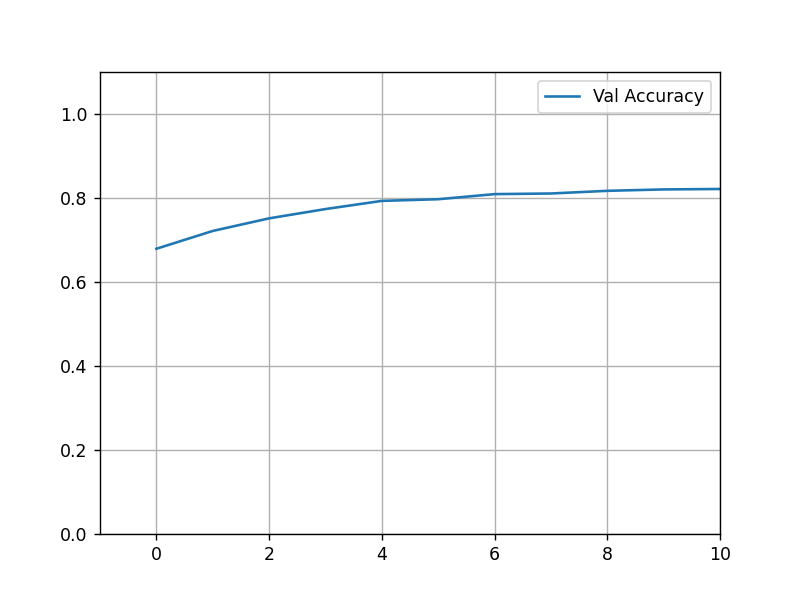

Epoch: 0.000000, Average loss: 1.378790, Train accuracy: 0.544381, Val accuracy: 0.679135
Epoch: 1.000000, Average loss: 1.006253, Train accuracy: 0.682456, Val accuracy: 0.721521
Epoch: 2.000000, Average loss: 0.851916, Train accuracy: 0.735505, Val accuracy: 0.751553
Epoch: 3.000000, Average loss: 0.797081, Train accuracy: 0.751510, Val accuracy: 0.773667
Epoch: 4.000000, Average loss: 0.718620, Train accuracy: 0.775620, Val accuracy: 0.793120
Epoch: 5.000000, Average loss: 0.695152, Train accuracy: 0.784357, Val accuracy: 0.797079
Epoch: 6.000000, Average loss: 0.646844, Train accuracy: 0.801061, Val accuracy: 0.809228
Epoch: 7.000000, Average loss: 0.634638, Train accuracy: 0.803826, Val accuracy: 0.810730
Epoch: 8.000000, Average loss: 0.608786, Train accuracy: 0.812084, Val accuracy: 0.817077
Epoch: 9.000000, Average loss: 0.602911, Train accuracy: 0.814234, Val accuracy: 0.820422
Epoch: 10.000000, Average loss: 0.589470, Train accuracy: 0.819182, Val accuracy: 0.821446
Epoch: 11

<IPython.core.display.Javascript object>


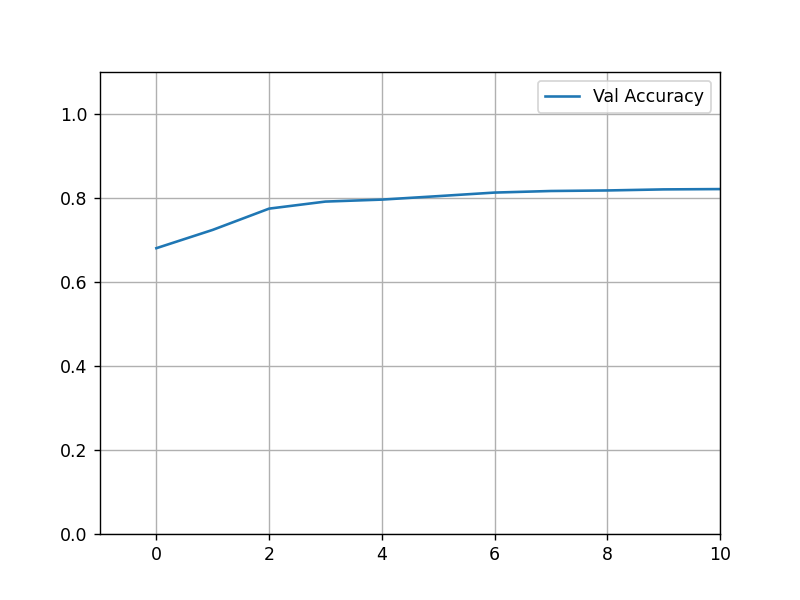

Epoch: 0.000000, Average loss: 1.384379, Train accuracy: 0.539194, Val accuracy: 0.680500
Epoch: 1.000000, Average loss: 0.994058, Train accuracy: 0.685749, Val accuracy: 0.724114
Epoch: 2.000000, Average loss: 0.827260, Train accuracy: 0.742620, Val accuracy: 0.774691
Epoch: 3.000000, Average loss: 0.770665, Train accuracy: 0.761065, Val accuracy: 0.791482
Epoch: 4.000000, Average loss: 0.695495, Train accuracy: 0.783572, Val accuracy: 0.796191
Epoch: 5.000000, Average loss: 0.676406, Train accuracy: 0.790960, Val accuracy: 0.804450
Epoch: 6.000000, Average loss: 0.644174, Train accuracy: 0.800925, Val accuracy: 0.812914
Epoch: 7.000000, Average loss: 0.624660, Train accuracy: 0.805464, Val accuracy: 0.816668
Epoch: 8.000000, Average loss: 0.610169, Train accuracy: 0.811845, Val accuracy: 0.817965
Epoch: 9.000000, Average loss: 0.601391, Train accuracy: 0.814115, Val accuracy: 0.820490
Epoch: 10.000000, Average loss: 0.590853, Train accuracy: 0.817903, Val accuracy: 0.821241
Epoch: 11

<IPython.core.display.Javascript object>


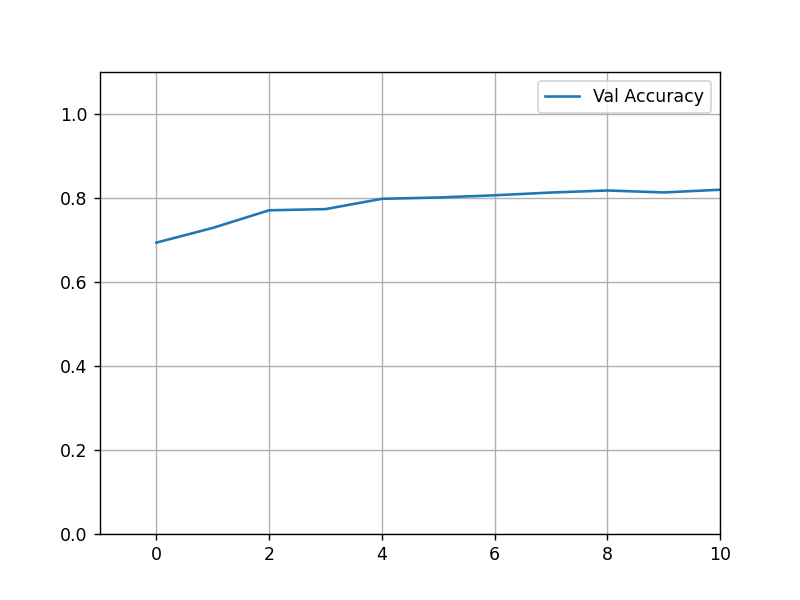

Epoch: 0.000000, Average loss: 1.391651, Train accuracy: 0.541924, Val accuracy: 0.693741
Epoch: 1.000000, Average loss: 1.004815, Train accuracy: 0.685527, Val accuracy: 0.728756
Epoch: 2.000000, Average loss: 0.842075, Train accuracy: 0.738457, Val accuracy: 0.770732
Epoch: 3.000000, Average loss: 0.788090, Train accuracy: 0.754394, Val accuracy: 0.773531
Epoch: 4.000000, Average loss: 0.710307, Train accuracy: 0.779050, Val accuracy: 0.798034
Epoch: 5.000000, Average loss: 0.689792, Train accuracy: 0.784766, Val accuracy: 0.801174
Epoch: 6.000000, Average loss: 0.644685, Train accuracy: 0.799730, Val accuracy: 0.806430
Epoch: 7.000000, Average loss: 0.631405, Train accuracy: 0.804099, Val accuracy: 0.812982
Epoch: 8.000000, Average loss: 0.610225, Train accuracy: 0.810600, Val accuracy: 0.817896
Epoch: 9.000000, Average loss: 0.602669, Train accuracy: 0.812323, Val accuracy: 0.813255
Epoch: 10.000000, Average loss: 0.591144, Train accuracy: 0.816862, Val accuracy: 0.819671
Epoch: 11

<IPython.core.display.Javascript object>


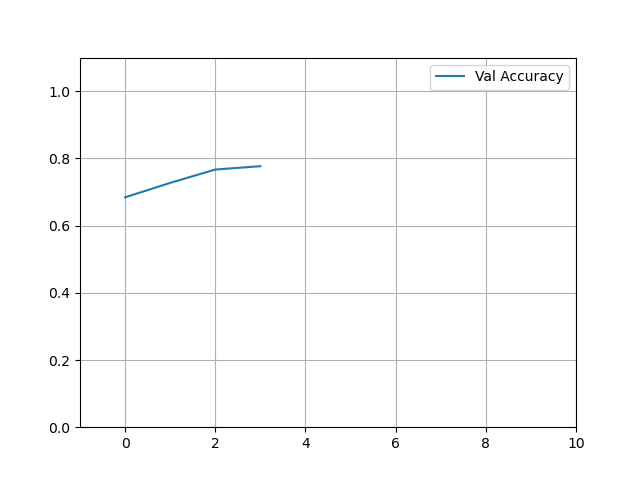

Epoch: 0.000000, Average loss: 1.411656, Train accuracy: 0.542863, Val accuracy: 0.684117
Epoch: 1.000000, Average loss: 1.003026, Train accuracy: 0.685715, Val accuracy: 0.727118
Epoch: 2.000000, Average loss: 0.847387, Train accuracy: 0.737672, Val accuracy: 0.766842
Epoch: 3.000000, Average loss: 0.793755, Train accuracy: 0.753012, Val accuracy: 0.776807


KeyboardInterrupt: 

In [7]:
# Experiment here!
%matplotlib notebook
from itertools import product

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, use_scheduler=False):
    # DONE: Added for graph    
    fig, ax = plt.subplots()
    ax.set_xlim((-1, 10))
    ax.set_ylim((0, 1.1))
#     ax2 = ax.twinx()
#     ax2.set_ylim((0, 1))
    ax.plot([0, 1, 2, 3, 4], [0, 0.5, 1, 0.5, 0])
#     ax2.plot([], [])
    ax.grid(True)
    ax.legend(["Val Accuracy"])
    plt.show()
    epoch_history =[]

    loss_history = []
    train_history = []
    val_history = []
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=2, gamma=0.5) 
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        epoch_history.append(epoch)

        # DONE: Added for interactive graph
        ax.lines[0].set_xdata(epoch_history)
        ax.lines[0].set_ydata(val_history)
#         ax2.lines[0].set_xdata(epoch_history)
#         ax2.lines[0].set_ydata(loss_history)
        fig.canvas.draw()
        fig.canvas.flush_events()

        print("Epoch: %f, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        if use_scheduler:
            scheduler.step()

    return loss_history, train_history, val_history

def get_multilayer_model(num, size):
        linear_cell = nn.Sequential(
        nn.Linear(size, size),
        nn.BatchNorm1d(size),
        nn.ReLU(inplace=True)
        )
        linear_list = []
        for idx in range(num):
                linear_list.append(linear_cell)
        nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, size),
                nn.BatchNorm1d(size),
                nn.ReLU(inplace=True),
                *linear_list,
                nn.Linear(size, 10) 
                )  
        return nn_model


linear_num_list = [1]
linear_size_num = [55]
lr_list = [0.0015, 0.003, 0.001]
weight_decay_list = [1e-4, 1e-5, 5e-5]
optimizerTypes = [optim.Adam]
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

best_classifier = None
best_val_accuracy = 0

best_loss_history = []
best_train_history = []
best_val_history = []


for optimizerType, linear_num, linear_size, lr, weight_decay in product(optimizerTypes, linear_num_list, linear_size_num, lr_list, weight_decay_list):
        nn_model = get_multilayer_model(linear_num, linear_size)
        optimizer = optimizerType(params=nn_model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 14, use_scheduler=True)
        accuracy = val_history[-1]
        print(f"linear num: {linear_num} | layer size: {linear_size} | optimizer: {optimizer} | lr: {lr} | weight_decay: {weight_decay} | loss: {loss_history[-1]} | accuracy: {accuracy}")
        if accuracy > best_val_accuracy:
                best_val_accuracy = accuracy
                best_loss_history = loss_history
                best_val_history = val_history
                best_classifier = nn_model


In [8]:
print("Best accuracy - ", best_val_accuracy)

Best accuracy -  tensor(0.8281)


In [10]:
print(best_classifier)

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=55, bias=True)
  (2): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Sequential(
    (0): Linear(in_features=55, out_features=55, bias=True)
    (1): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (5): Linear(in_features=55, out_features=10, bias=True)
)


In [11]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_classifier, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8002
